In [1]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

## Config GPU CUDA

In [1]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {cuda_id}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

## 1. Build Data loading function

In [4]:
import gdown

In [5]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'D:\\NCKH\\LipFormer\\data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall(output)

In [5]:
def load_video(path:str)->List[float]:
    cap = cv2.VideoCapture(path)
    frames = []
    
    # Loop through all the frames
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220, :]) # isolating the mount location
    cap.release()
    
    mean = tf.math.reduce_mean(frames, axis=0)
    std = tf.math.reduce_std(tf.cast(frames, dtype=tf.float32), axis=0)
    return tf.cast((frames - mean), dtype=tf.float32) / std # Standardize the feature

In [6]:
vocabs = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocabs, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"Vocabulary is: {char_to_num.get_vocabulary()}")
print(f"Size: {char_to_num.vocabulary_size()}")


Vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
Size: 40


In [8]:
def load_alignments(path: str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
        f.close()
    
    tokens = list()
    for line in lines:
        word = line.strip().split()
        if word[2] == 'sil':
                tokens = [*tokens, ' ', word[2]]
                
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [9]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    return frames, alignments

In [10]:
test_path = '.\\data\\s1\\bbaf2n.mpg'

In [11]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

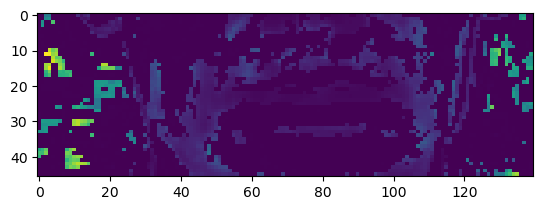

In [12]:
plt.imshow(frames[65])

In [13]:
"".join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

'sil sil'

In [14]:
def mappable_funct(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## 2. Build data pipeline

In [15]:
import tensorflow as tf

In [16]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(5000)
data = data.map(mappable_funct)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

In [17]:
frames, alignments = data.as_numpy_iterator().next()

In [18]:
len(frames)

2

In [19]:
test = data.as_numpy_iterator()

In [20]:
val = test.next()

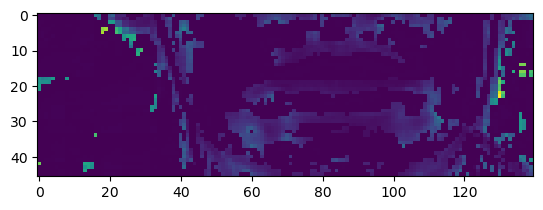

In [21]:
plt.imshow(val[0][0][0])

In [22]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'sil sil'>

## 3. Design Lip network

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [28]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [29]:
model = Sequential()

model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='orthogonal', return_sequences=True)))
model.add(Dropout(0.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [30]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 75, 6375)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
y_hat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [32]:
tf.argmax(y_hat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([31, 31, 31, 31, 31, 31, 31, 28, 22, 18, 18, 22, 22, 22, 28, 22, 28,
       28, 28, 22, 28, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 18, 18, 20,
       29, 29, 29, 29, 29, 29, 29, 29,  3, 29,  3,  3,  3,  3, 29, 29, 29,
        3, 20, 20, 20, 20, 20, 20, 20, 20, 20,  3,  3,  7, 32, 32, 29, 29,
       20, 20, 20, 20, 20, 20, 20], dtype=int64)>

In [33]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in y_hat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'2222222?vrrvvv?v???v?vvvvvvvvvvrrt!!!!!!!!c!cccc!!!ctttttttttccg33!!ttttttt'>

In [34]:
model.input_shape

(None, 75, 46, 140, 1)

In [35]:
model.output_shape

(None, 75, 41)

## 4. Setup train options and train